## Predicting Forest Fire Prevalence Based on Rising Temperatures in the State of Michigan, USA

Based on: https://github.com/Joseph-Vanliew/Fire-Occurrence-SARIMAX-Model/blob/main/Fire_Occurance_SARIMAX.ipynb

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from pandas import to_datetime
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import nsdiffs
from statsmodels.tsa.seasonal import seasonal_decompose, STL
import pmdarima as pm
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import durbin_watson

In [3]:
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter('ignore', ValueWarning)

## Dataset

In [4]:
url1 = ('https://raw.githubusercontent.com/Joseph-Vanliew/Fire-Occurrence-SARIMAX-Model/refs/heads/main/Data/Extreme_Heat_Days_By_County.csv')
url2 = ('https://raw.githubusercontent.com/Joseph-Vanliew/Fire-Occurrence-SARIMAX-Model/refs/heads/main/Data/Average_Michigan_Monthly_Temperature.csv')


#Extreme Heat Days (Yearly)
extreme_heat_days_df = pd.read_csv(url1)

#Average Monthly Temperature For All of Michigan
average_monthly_temp_df = pd.read_csv(url2, skiprows=4) # first 4 rows have multi-column headers we don't need

#Fire Dataset import
fire_data_df = pd.read_csv('data/Fires_MI.csv')

In [5]:
extreme_heat_days_df.head()

,County,Year(s),Number of Extreme Heat Days
0,Alcona,1979,1
1,Alcona,1980,2
2,Alcona,1981,2
3,Alcona,1982,1
4,Alcona,1983,9


In [6]:
average_monthly_temp_df.head()

,Date,Value,Anomaly
0,194001,14.3,-4.8
1,194002,21.0,0.3
2,194003,23.1,-6.9
3,194004,38.1,-4.6
4,194005,51.1,-3.1


In [7]:
average_monthly_temp_df.tail()

,Date,Value,Anomaly
1005,202310,50.5,2.4
1006,202311,36.3,0.8
1007,202312,35.1,10.5
1008,202401,24.4,5.3
1009,202402,31.9,11.2


In [8]:
# Convert YYYYMM integers to datetime (default is first day of month)
average_monthly_temp_df['Date'] = pd.to_datetime(average_monthly_temp_df['Date'], format='%Y%m')

# Offset to the last day of each month
average_monthly_temp_df['Date'] = average_monthly_temp_df['Date'] + pd.offsets.MonthEnd(0)

# Make column 'Date' Index
average_monthly_temp_df['Date'] = pd.to_datetime(average_monthly_temp_df['Date'])
average_monthly_temp_df = average_monthly_temp_df.set_index(['Date'])

# Filter using the datetime index
ave_mon_temp_df = average_monthly_temp_df[
    (average_monthly_temp_df.index >= '1992-02-29') & 
    (average_monthly_temp_df.index <= '2015-11-30')
]
# Show dataframe
ave_mon_temp_df    #<==== Exogenour variables

,Value,Anomaly
Date,,
1992-02-29,25.1,4.4
1992-03-31,29.0,-1.0
1992-04-30,40.2,-2.5
1992-05-31,54.5,0.3
1992-06-30,60.3,-3.6
...,...,...
2015-07-31,67.9,-0.5
2015-08-31,66.9,0.3
2015-09-30,64.6,5.5


In [9]:
fire_data_df.head()  # Target Series

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,...,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
0,2215,2230,FS-1423712,FED,FS-FIRESTAT,FS,USMIHMF,Huron-Manistee National Forest,0904,Huron-Manistee National Forest,...,B,43.571111,-85.979167,13.0,STATE OR PRIVATE,MI,123,123.0,Newaygo,NaN
1,2324,2339,FS-1424005,FED,FS-FIRESTAT,FS,USMIHMF,Huron-Manistee National Forest,0904,Huron-Manistee National Forest,...,C,43.944167,-82.990278,13.0,STATE OR PRIVATE,MI,85,85.0,Lake,NaN
2,2336,2351,FS-1424035,FED,FS-FIRESTAT,FS,USMIHMF,Huron-Manistee National Forest,0904,Huron-Manistee National Forest,...,B,43.430000,-85.806667,13.0,STATE OR PRIVATE,MI,123,123.0,Newaygo,NaN
3,2339,2354,FS-1424039,FED,FS-FIRESTAT,FS,USMIHMF,Huron-Manistee National Forest,0904,Huron-Manistee National Forest,...,A,43.590833,-85.804167,13.0,STATE OR PRIVATE,MI,123,123.0,Newaygo,NaN
4,2355,2370,FS-1424066,FED,FS-FIRESTAT,FS,USMIHMF,Huron-Manistee National Forest,0904,Huron-Manistee National Forest,...,B,43.453611,-85.792500,13.0,STATE OR PRIVATE,MI,123,123.0,Newaygo,NaN


In [10]:
columns_to_drop = [
    'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM', 'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID', 'NWCG_REPORTING_UNIT_NAME',
    'SOURCE_REPORTING_UNIT', 'SOURCE_REPORTING_UNIT_NAME', 'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID',
    'MTBS_FIRE_NAME', 'COMPLEX_NAME', 'DISCOVERY_TIME', 'CONT_DATE', 'CONT_DOY', 'CONT_TIME', 'OWNER_CODE',
    'OWNER_DESCR', 'Shape','COUNTY','FIPS_CODE', 'DISCOVERY_DOY', 'FIRE_SIZE_CLASS','LOCAL_INCIDENT_ID','LOCAL_FIRE_REPORT_ID'
]

fire_data_df.drop(columns=columns_to_drop, inplace=True)

fire_data_df.head()

,OBJECTID,FOD_ID,FPA_ID,FIRE_CODE,FIRE_NAME,FIRE_YEAR,DISCOVERY_DATE,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,FIRE_SIZE,LATITUDE,LONGITUDE,STATE,FIPS_NAME
0,2215,2230,FS-1423712,BE1X,DITLOW FIRE,2005,2453461.5,5.0,Debris Burning,2.0,43.571111,-85.979167,MI,Newaygo
1,2324,2339,FS-1424005,BNC2,UNDERWOOD HILL FIRE,2005,2453471.5,2.0,Equipment Use,66.0,43.944167,-82.990278,MI,Lake
2,2336,2351,FS-1424035,BE1X,COOPER FIRE,2005,2453473.5,9.0,Miscellaneous,1.5,43.430000,-85.806667,MI,Newaygo
3,2339,2354,FS-1424039,BE1X,DIAMOND LAKE FIRE,2005,2453474.5,5.0,Debris Burning,0.1,43.590833,-85.804167,MI,Newaygo
4,2355,2370,FS-1424066,BE1X,EMERALD LAKE FIRE,2005,2453475.5,7.0,Arson,2.0,43.453611,-85.792500,MI,Newaygo


In [11]:
# Convert Julian dates in the DISCOVERY_DATE column to Gregorian dates
fire_data_df['DISCOVERY_DATE'] = to_datetime(fire_data_df['DISCOVERY_DATE'], origin='julian', unit='D')

# Format the Gregorian dates as MM/YYYY to match monthly temperature
fire_data_df['DISCOVERY_DATE'] = fire_data_df['DISCOVERY_DATE'].dt.strftime('%d/%m/%Y')

fire_data_df.rename(columns={'FIPS_NAME': 'COUNTY'}, inplace=True)
print('Years:',fire_data_df.FIRE_YEAR.min(),'->',fire_data_df.FIRE_YEAR.max())

Years: 1992 -> 2015


In [12]:
fire_data_df.head(3)

,OBJECTID,FOD_ID,FPA_ID,FIRE_CODE,FIRE_NAME,FIRE_YEAR,DISCOVERY_DATE,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,FIRE_SIZE,LATITUDE,LONGITUDE,STATE,COUNTY
0,2215,2230,FS-1423712,BE1X,DITLOW FIRE,2005,01/04/2005,5.0,Debris Burning,2.0,43.571111,-85.979167,MI,Newaygo
1,2324,2339,FS-1424005,BNC2,UNDERWOOD HILL FIRE,2005,11/04/2005,2.0,Equipment Use,66.0,43.944167,-82.990278,MI,Lake
2,2336,2351,FS-1424035,BE1X,COOPER FIRE,2005,13/04/2005,9.0,Miscellaneous,1.5,43.430000,-85.806667,MI,Newaygo


In [13]:
# Handle nulls in 'FIRE_CODE'
fire_data_df['FIRE_CODE'] = fire_data_df['FIRE_CODE'].fillna('Unknown')

# Handle nulls in 'FIRE_NAME'
fire_data_df['FIRE_NAME'] = fire_data_df['FIRE_NAME'].fillna('No Name')

# Drop rows where 'COUNTY' column values are null
fire_data_df = fire_data_df.dropna(subset=['COUNTY'])

fire_data_df.isnull().sum()

OBJECTID            0
FOD_ID              0
FPA_ID              0
FIRE_CODE           0
FIRE_NAME           0
FIRE_YEAR           0
DISCOVERY_DATE      0
STAT_CAUSE_CODE     0
STAT_CAUSE_DESCR    0
FIRE_SIZE           0
LATITUDE            0
LONGITUDE           0
STATE               0
COUNTY              0
dtype: int64

In [14]:
extreme_heat_days_df.isnull().sum()

County                         0
Year(s)                        0
Number of Extreme Heat Days    0
dtype: int64

In [15]:
average_monthly_temp_df.isnull().sum()

Value      0
Anomaly    0
dtype: int64

In [16]:
final_df = fire_data_df

#indexing by Discovery_Date
final_df.DISCOVERY_DATE = pd.to_datetime(final_df.DISCOVERY_DATE, format = '%d/%m/%Y')
final_df.set_index("DISCOVERY_DATE", inplace=True)
final_df.head(3)

,OBJECTID,FOD_ID,FPA_ID,FIRE_CODE,FIRE_NAME,FIRE_YEAR,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,FIRE_SIZE,LATITUDE,LONGITUDE,STATE,COUNTY
DISCOVERY_DATE,,,,,,,,,,,,,
2005-04-01,2215,2230,FS-1423712,BE1X,DITLOW FIRE,2005,5.0,Debris Burning,2.0,43.571111,-85.979167,MI,Newaygo
2005-04-11,2324,2339,FS-1424005,BNC2,UNDERWOOD HILL FIRE,2005,2.0,Equipment Use,66.0,43.944167,-82.990278,MI,Lake
2005-04-13,2336,2351,FS-1424035,BE1X,COOPER FIRE,2005,9.0,Miscellaneous,1.5,43.430000,-85.806667,MI,Newaygo


In [17]:
first_index_str = final_df.index[0].strftime('%Y-%m-%d')
print(first_index_str)

2005-04-01


In [18]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9857 entries, 2005-04-01 to 2015-05-02
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   OBJECTID          9857 non-null   int64  
 1   FOD_ID            9857 non-null   int64  
 2   FPA_ID            9857 non-null   object 
 3   FIRE_CODE         9857 non-null   object 
 4   FIRE_NAME         9857 non-null   object 
 5   FIRE_YEAR         9857 non-null   int64  
 6   STAT_CAUSE_CODE   9857 non-null   float64
 7   STAT_CAUSE_DESCR  9857 non-null   object 
 8   FIRE_SIZE         9857 non-null   float64
 9   LATITUDE          9857 non-null   float64
 10  LONGITUDE         9857 non-null   float64
 11  STATE             9857 non-null   object 
 12  COUNTY            9857 non-null   object 
dtypes: float64(4), int64(3), object(6)
memory usage: 1.1+ MB


## Exploratory Data Analysis

In [19]:
fires_per_year = final_df.groupby('FIRE_YEAR').size()
fires_per_year

FIRE_YEAR
1992    589
1993    239
1994    625
1995    591
1996    376
1997     89
1998     79
1999    127
2000     76
2001    398
2002    302
2003    704
2004    442
2005    619
2006    521
2007    503
2008    439
2009    472
2010    561
2011    192
2012    693
2013    437
2014    263
2015    520
dtype: int64

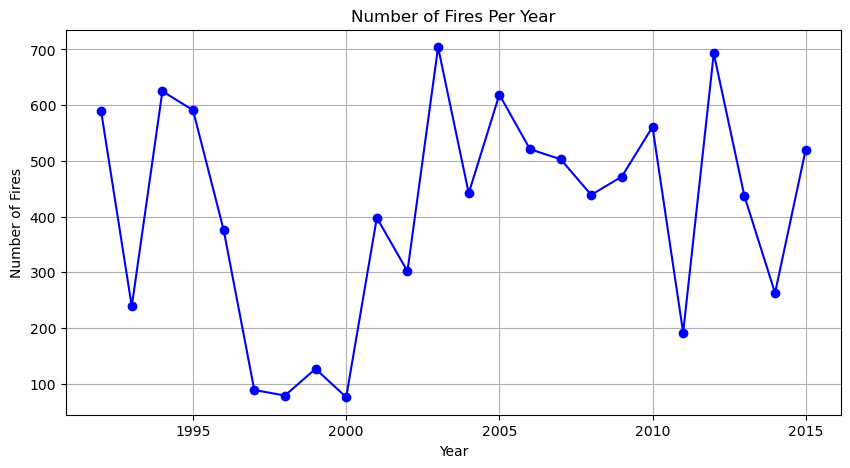

In [20]:
fires_per_year.plot(kind='line', figsize=(10, 5), marker='o', linestyle='-', color='b')
plt.title('Number of Fires Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Fires')
plt.grid(True)
plt.show()

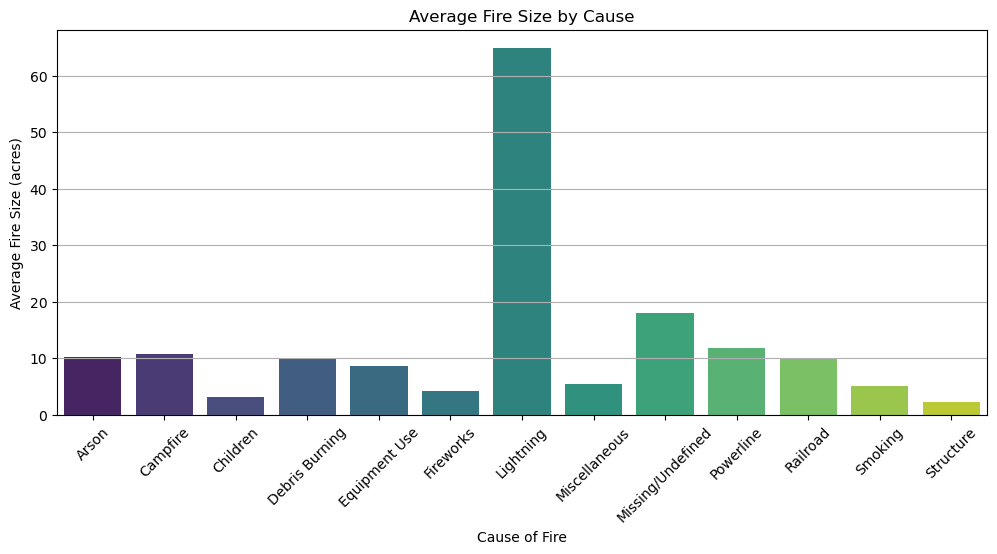

In [21]:
# Calculate the average fire size for each cause
average_fire_size_by_cause = final_df.groupby('STAT_CAUSE_DESCR')['FIRE_SIZE'].mean().reset_index()

# Create the bar plot
plt.figure(figsize=(12, 5))
bar_plot = sns.barplot(x='STAT_CAUSE_DESCR', 
                       y='FIRE_SIZE', 
                       data=average_fire_size_by_cause, 
                       palette='viridis', 
                       hue='STAT_CAUSE_DESCR', 
                       legend=False)
plt.title('Average Fire Size by Cause')
plt.xlabel('Cause of Fire')
plt.ylabel('Average Fire Size (acres)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show();

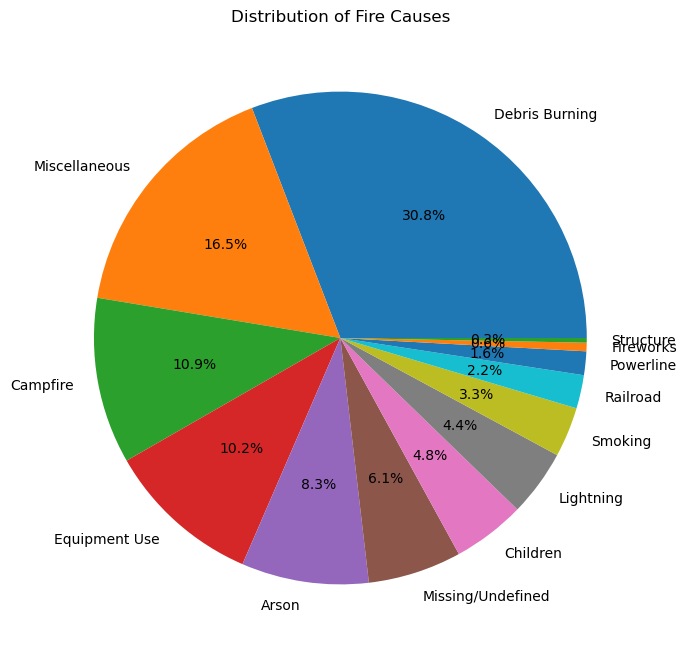

In [22]:
cause_counts = final_df['STAT_CAUSE_DESCR'].value_counts()

plt.figure(figsize=(12, 8))
cause_counts.plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Fire Causes')
plt.ylabel('')
plt.show()

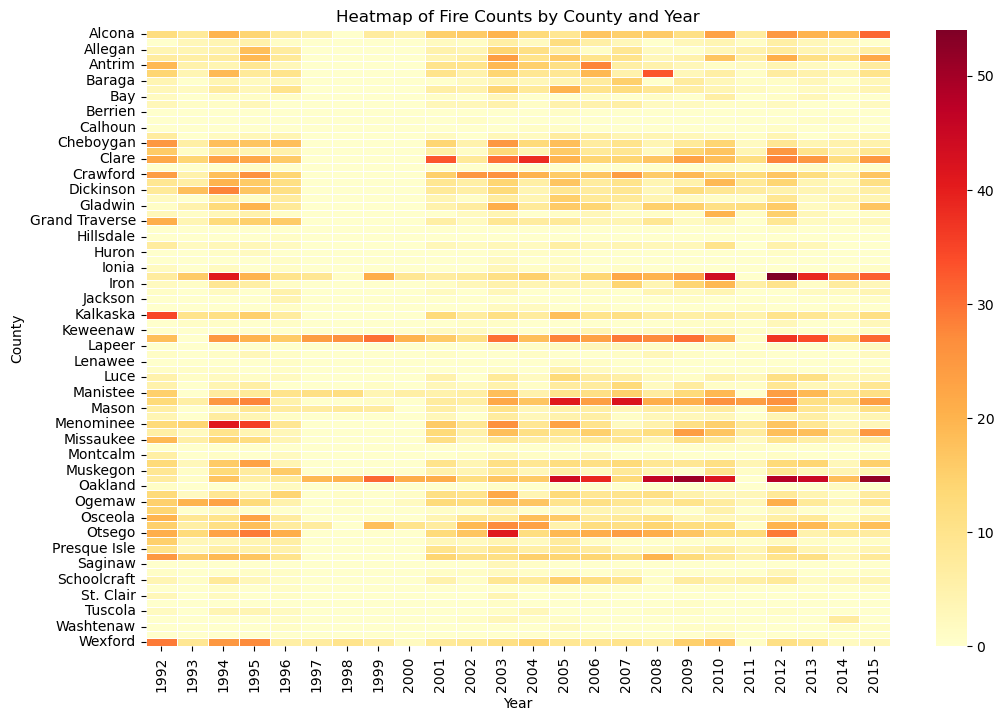

In [23]:
# Creating a pivot table for the heatmap
heatmap_data = final_df.pivot_table(values='OBJECTID', 
                                    index='COUNTY', 
                                    columns='FIRE_YEAR', 
                                    aggfunc='count', 
                                    fill_value=0)

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='YlOrRd', linewidths=.5)
plt.title('Heatmap of Fire Counts by County and Year')
plt.xlabel('Year')
plt.ylabel('County')
plt.show()

# Modeling

In [24]:
# Resample the dataset to count the number of fires per month
mfc = final_df.resample('ME').size()  # monthly_fire_counts

mfc

DISCOVERY_DATE
1992-02-29      1
1992-03-31      2
1992-04-30     74
1992-05-31    328
1992-06-30    123
             ... 
2015-07-31     45
2015-08-31     22
2015-09-30      6
2015-10-31     14
2015-11-30      3
Freq: ME, Length: 286, dtype: int64

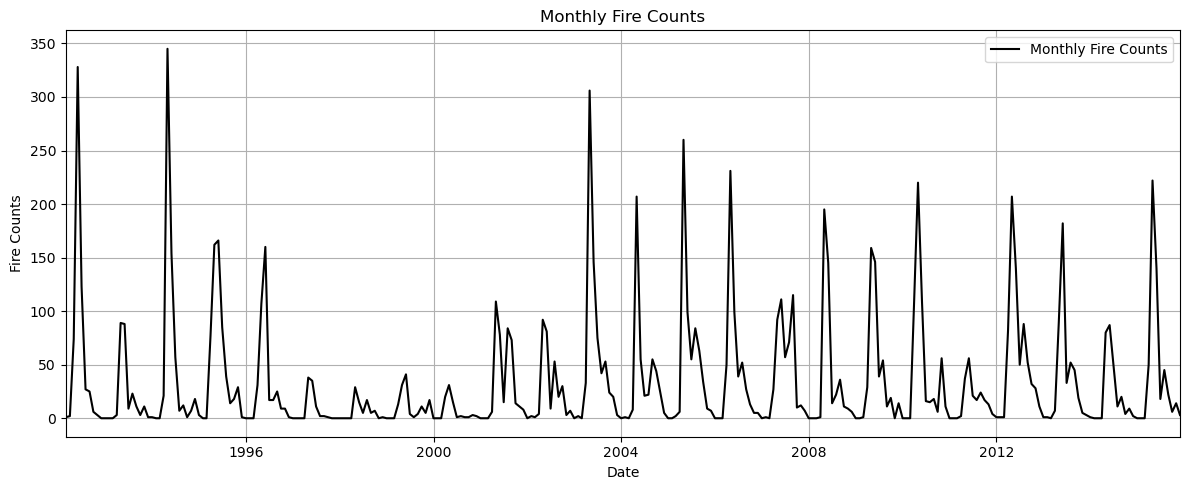

In [25]:
# Plot actual and fitted serie
plt.figure(figsize=(12, 5))                                      

plt.plot(mfc.index, mfc, label='Monthly Fire Counts', color= 'black')     

plt.title('Monthly Fire Counts')                      
plt.xlabel('Date')                                        
plt.ylabel('Fire Counts')  
plt.xlim(pd.to_datetime('1992-02-29'), pd.to_datetime('2015-11-30'))
plt.grid(True)                                            
plt.legend()                                             
plt.tight_layout()                                       
plt.show();

In [26]:
df = mfc.reset_index()                         # Reset the index to convert it into columns
df.columns = ['DISCOVERY_DATE', 'FIRE_COUNT']  # Rename columns for clarity

# Set 'DISCOVERY_DATE' as the index
df.set_index('DISCOVERY_DATE', inplace=True)

# Sort the DataFrame by index (date)
df.sort_index(inplace=True)

df

,FIRE_COUNT
DISCOVERY_DATE,
1992-02-29,1
1992-03-31,2
1992-04-30,74
1992-05-31,328
1992-06-30,123
...,...
2015-07-31,45
2015-08-31,22
2015-09-30,6


In [27]:
# Merge based on index (Date)
df = df.join(ave_mon_temp_df)

df

,FIRE_COUNT,Value,Anomaly
DISCOVERY_DATE,,,
1992-02-29,1,25.1,4.4
1992-03-31,2,29.0,-1.0
1992-04-30,74,40.2,-2.5
1992-05-31,328,54.5,0.3
1992-06-30,123,60.3,-3.6
...,...,...,...
2015-07-31,45,67.9,-0.5
2015-08-31,22,66.9,0.3
2015-09-30,6,64.6,5.5


In [28]:
# Split the data
cutoff = pd.to_datetime("2012-01-01")

train = df[df.index < cutoff]
test = df[df.index >= cutoff]

# Show results
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print()
print(train.tail())
print()
print(test.head())

Train shape: (239, 3)
Test shape: (47, 3)

                FIRE_COUNT  Value  Anomaly
DISCOVERY_DATE                            
2011-08-31              24   68.3      1.7
2011-09-30              17   58.7     -0.4
2011-10-31              13   49.7      1.6
2011-11-30               4   39.9      4.4
2011-12-31               1   29.9      5.3

                FIRE_COUNT  Value  Anomaly
DISCOVERY_DATE                            
2012-01-31               1   25.1      6.0
2012-02-29               1   28.4      7.7
2012-03-31              82   44.7     14.7
2012-04-30             207   43.9      1.2
2012-05-31             140   59.0      4.8


In [29]:
fire_series = train['FIRE_COUNT']

In [30]:
def determine_nonseasonal_d(series, max_d=2, alpha=0.05):

    d = 0

    adf_result = adfuller(series)                # Run ADF test on the original series
    p_value = adf_result[1]
    print(f"d = {d} | ADF Statistic = {adf_result[0]:.4f}, p-value = {p_value:.4f}")

    if p_value < alpha:                          # If the original series is stationary
        
        return d
        
    else:
        while p_value > alpha and d < max_d:
            d += 1
            series = np.diff(series, n=1)        # Perform first-order differencing
            ad_fuller_result1 = adfuller(series)  
            p_value = ad_fuller_result1[1]
            print(f"d = {d} | ADF Statistic = {ad_fuller_result1[0]:.4f}, p-value = {p_value:.4f}")   
            
        return d  

d = determine_nonseasonal_d(fire_series)
print(f"\nNon-seasonal differencing term (d): {d}")

d = 0 | ADF Statistic = -2.4803, p-value = 0.1203
d = 1 | ADF Statistic = -9.2320, p-value = 0.0000

Non-seasonal differencing term (d): 1


In [31]:
def determine_seasonal_D(series, m=12):
    
    # Get seasonal differencing terms using CH and OCSB tests
    D = max(nsdiffs(series, m=m, test='ch'),
            nsdiffs(series, m=m, test='ocsb'))

    return D

for m in  [4, 7, 12, 24, 30, 52]:

    D = determine_seasonal_D(fire_series, m)
    print(f'Seasonal differencing term (D) for {m}: {D}')

Seasonal differencing term (D) for 4: 0
Seasonal differencing term (D) for 7: 0
Seasonal differencing term (D) for 12: 0
Seasonal differencing term (D) for 24: 0
Seasonal differencing term (D) for 30: 0
Seasonal differencing term (D) for 52: 0


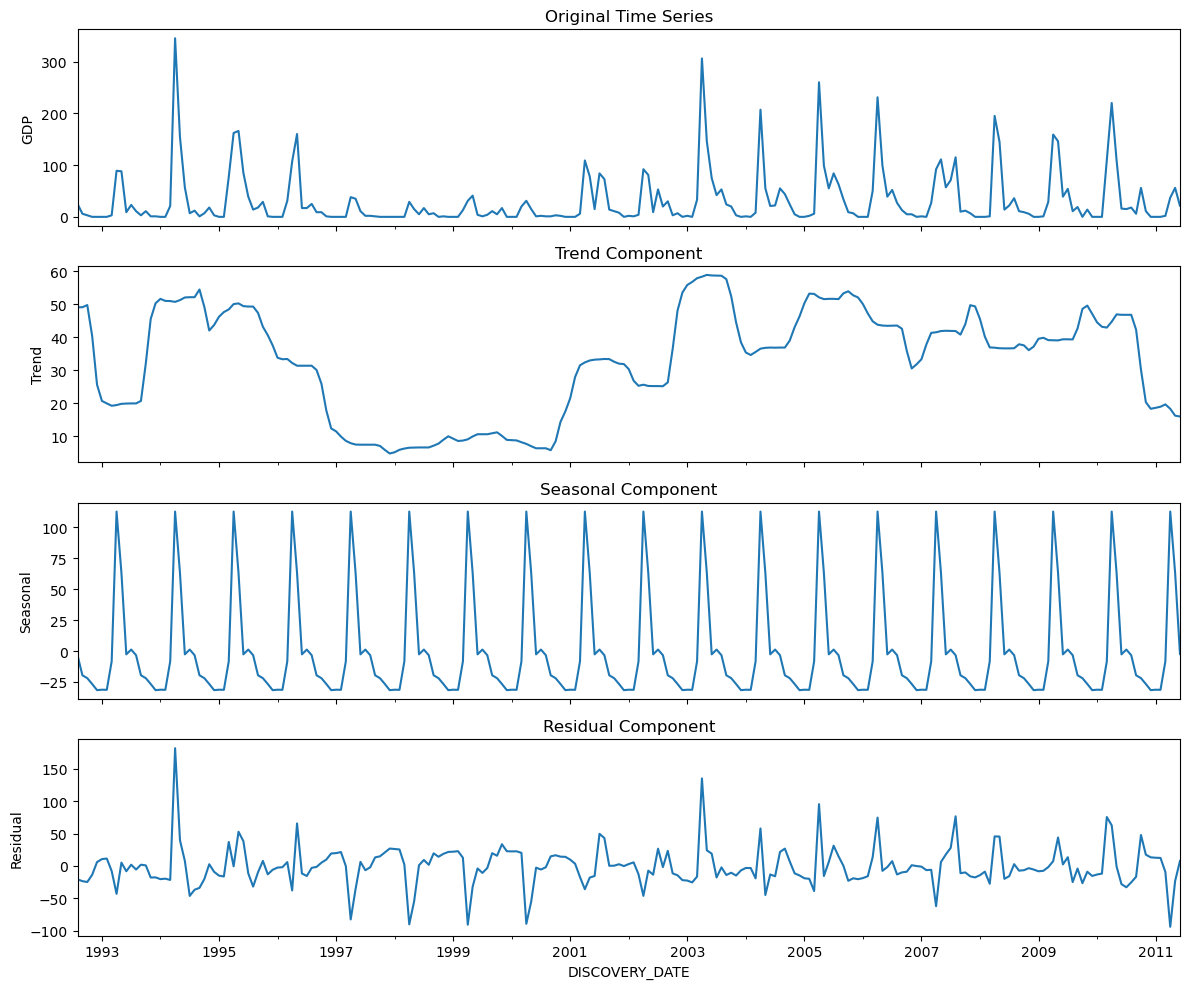

In [32]:
result = seasonal_decompose(fire_series, model='aditive', period=12)

trend = result.trend.dropna()
seasonal = result.seasonal.dropna()
residual = result.resid.dropna()


# Plot the decomposition
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

result.observed.plot(ax=axes[0], title="Original Time Series")
axes[0].set_ylabel('GDP')

trend.plot(ax=axes[1], title="Trend Component")
axes[1].set_ylabel('Trend')

seasonal.plot(ax=axes[2], title="Seasonal Component")
axes[2].set_ylabel('Seasonal')

residual.plot(ax=axes[3], title="Residual Component")
axes[3].set_ylabel('Residual')

plt.tight_layout()
plt.show()

In [33]:
# Perform a full search over the same grid as your manual SARIMAX model
auto_model = pm.auto_arima(
    fire_series,                # The time series data
    seasonal=True,              # Enable seasonal component
    m=12,                       # Seasonal period
    d=1,                        # Set differencing 
    D=0,                        # Set seasonal differencing
    start_p=0, max_p=3,         # p 
    start_q=0, max_q=3,         # q 
    start_P=0, max_P=3,         # P 
    start_Q=0, max_Q=3,         # Q 
    stepwise=False,             # Disable stepwise search (enable full grid search)
    trace=False,                # Print model search progress
    error_action='ignore',      # Ignore errors and continue
    suppress_warnings=True,     # Suppress convergence warnings
    information_criterion='aic' # Use AIC to choose the best model
)

# Print the best model found
print(f"Best model: SARIMA{auto_model.order}{auto_model.seasonal_order}")

Best model: SARIMA(0, 1, 1)(1, 0, 1, 12)


In [34]:
def combinator(items, r=1):
    combo = [i for i in product(*items, repeat=r)]  # Generate Cartesian product of input lists
    return combo                                    # Return the list of combinations


P_ns, Q_ns = [0, 1, 2, 3], [0, 1, 2, 3]       # Define search ranges for non-seasonal parameters (p, q)
P_s, Q_s = [0, 1, 2, 3], [0, 1, 2, 3]         # Define search ranges for seasonal parameters (P, Q)
d = 1
D = 0
S = 12

total = len(P_ns) * len(Q_ns) * len(P_s) * len(Q_s)
print(f'Total number of models: {total}')

vals = combinator([P_ns, [d], Q_ns, P_s, [D], Q_s])  # Generate all combinations of SARIMA parameter sets

score = {}                                     # Dictionary to store model evaluation metrics

for i, (p, d, q, P, D, Q) in enumerate(vals):  # Iterate over all parameter combinations
    
    if i % 15 == 0:                            # Print progress every 15 models
        print(f'Running model #{i} using SARIMA({p},{d},{q})({P},{D},{Q},{S})')

    m = SARIMAX(fire_series,                   # Define SARIMA model with current parameter set
                order=(p,d,q), 
                seasonal_order=(P, D, Q, S),   
                enforce_stationarity=False)    # Allow non-stationary models for broader search

    res = m.fit(disp=0, low_memory=True)       # Fit the model silently

    score[i] = {                               # Store model results and evaluation metrics
        'non-seasonal order': (p, d, q),      
        'seasonal order': (P, D, Q),
        'AIC': res.aic,                        # Akaike Information Criterion
        'model': res                           # Fitted model object
    }
print()

pd.DataFrame(score).T.sort_values(by='AIC').reset_index().head()

Total number of models: 256
Running model #0 using SARIMA(0,1,0)(0,0,0,12)
Running model #15 using SARIMA(0,1,0)(3,0,3,12)
Running model #30 using SARIMA(0,1,1)(3,0,2,12)
Running model #45 using SARIMA(0,1,2)(3,0,1,12)
Running model #60 using SARIMA(0,1,3)(3,0,0,12)
Running model #75 using SARIMA(1,1,0)(2,0,3,12)
Running model #90 using SARIMA(1,1,1)(2,0,2,12)
Running model #105 using SARIMA(1,1,2)(2,0,1,12)
Running model #120 using SARIMA(1,1,3)(2,0,0,12)
Running model #135 using SARIMA(2,1,0)(1,0,3,12)
Running model #150 using SARIMA(2,1,1)(1,0,2,12)
Running model #165 using SARIMA(2,1,2)(1,0,1,12)
Running model #180 using SARIMA(2,1,3)(1,0,0,12)
Running model #195 using SARIMA(3,1,0)(0,0,3,12)
Running model #210 using SARIMA(3,1,1)(0,0,2,12)
Running model #225 using SARIMA(3,1,2)(0,0,1,12)
Running model #240 using SARIMA(3,1,3)(0,0,0,12)
Running model #255 using SARIMA(3,1,3)(3,0,3,12)



,index,non-seasonal order,seasonal order,AIC,model
0,119,"(1, 1, 3)","(1, 0, 3)",1931.227071,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
1,55,"(0, 1, 3)","(1, 0, 3)",1932.23828,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
2,183,"(2, 1, 3)","(1, 0, 3)",1932.385348,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
3,127,"(1, 1, 3)","(3, 0, 3)",1932.666839,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
4,123,"(1, 1, 3)","(2, 0, 3)",1932.831753,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...


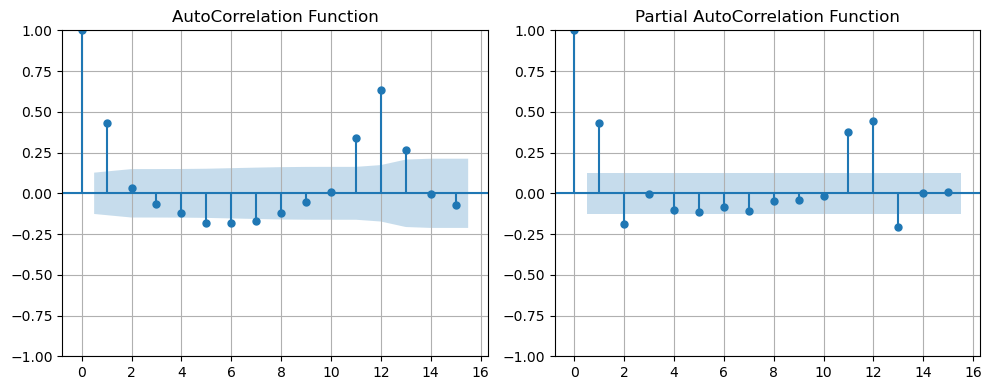

In [35]:
# Create a 1x2 grid for subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))  

# Plot AutoCorrelation Function
plot_acf(fire_series, ax=axes[0], lags=15)
axes[0].set_title("AutoCorrelation Function", fontsize=12)
axes[0].grid(True)

# Plot Partial Autocorrelation Function
plot_pacf(fire_series, ax=axes[1], lags=15)
axes[1].set_title("Partial AutoCorrelation Function", fontsize=12)
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [36]:
# Define the SARIMA (p,d,q)(P,D,Q,S) model
model_113 = SARIMAX(fire_series,                         # Time series data
                    order=(1, 1, 3),                     # Non-seasonal order (p,d,q)
                    seasonal_order=(1, 0, 3, 12),        # Seasonal order (P,D,Q,S)
                    enforce_stationarity=False)          # Allow non-stationary behavior

# Fit the model
model_fit_113 = model_113.fit()

# Display summary of the model
print(model_fit_113.summary())

                                     SARIMAX Results                                      
Dep. Variable:                         FIRE_COUNT   No. Observations:                  239
Model:             SARIMAX(1, 1, 3)x(1, 0, 3, 12)   Log Likelihood                -956.614
Date:                            Mon, 05 May 2025   AIC                           1931.227
Time:                                    15:38:54   BIC                           1960.821
Sample:                                02-29-1992   HQIC                          1943.206
                                     - 12-31-2011                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4472      0.336     -1.330      0.183      -1.106       0.212
ma.L1         -0.1962      0.499   

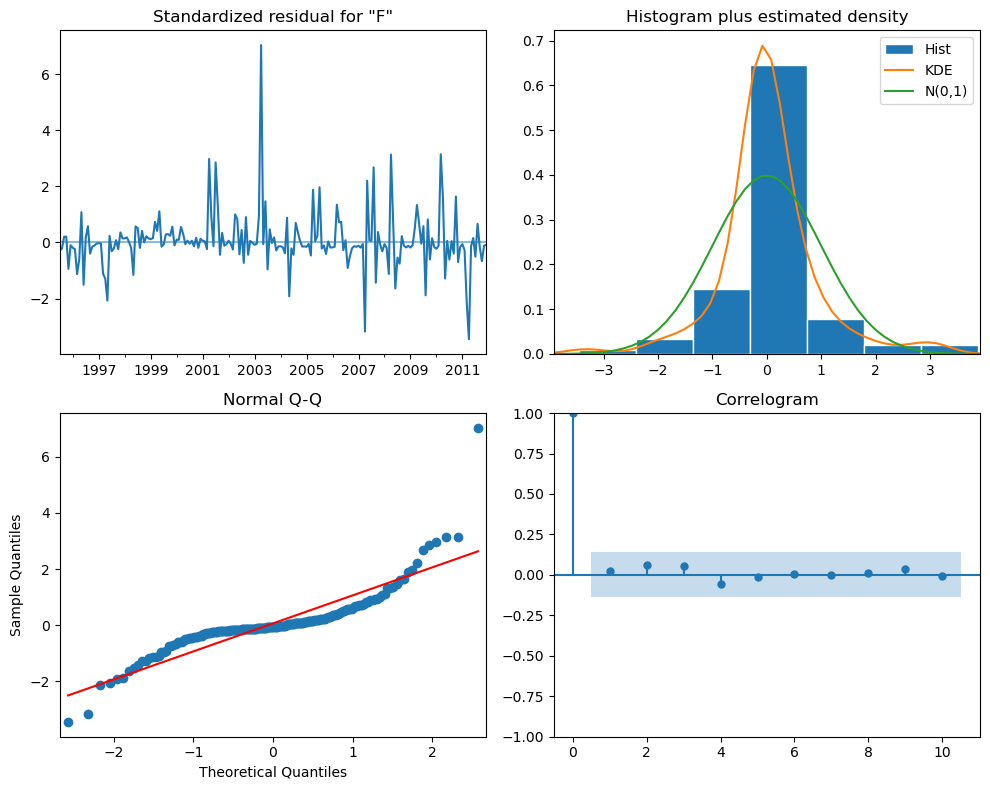

In [37]:
# Diagnostic plots for the model, including residuals and other model checks
model_fit_113.plot_diagnostics(figsize=(10, 8))
plt.tight_layout()
plt.show();

In [38]:
# Extract the residuals (errors) from the fitted model
residuals = model_fit_113.resid  

# Apply the Ljung-Box test on the residuals, on 10 lags.
df_residuals = acorr_ljungbox(residuals, np.arange(1, 11, 1))

# Check if all values in 'lb_pvalue' are lower than 0.05
if (df_residuals['lb_pvalue'] > 0.05).all():
    print('All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.\n')
else:
    print('There are p-values < 0.05; Ha: Residuals are autocorrelated.\n')

# Show Residuals
df_residuals

There are p-values < 0.05; Ha: Residuals are autocorrelated.



,lb_stat,lb_pvalue
1,0.143310,0.705012
2,9.382512,0.009175
3,10.135993,0.017445
4,10.557774,0.032010
5,10.846403,0.054512
6,10.852016,0.093059
7,11.046737,0.136593
8,11.084386,0.196963
9,12.353530,0.194105
10,12.531914,0.251032


In [39]:
from statsmodels.stats.stattools import durbin_watson

# Dublin-Watson Test
dw_statistic = durbin_watson(residuals)

print(f'Durbin-Watson statistic: {dw_statistic:.4f}')

# Automatic conclusion based on the DW statistic
if dw_statistic < 0.5:
    print("Conclusion: Strong Positive autocorrelation.")
elif 0.5 <= dw_statistic <= 1.5:
    print("Conclusion: Evidence of positive autocorrelation.")
elif 1.5 <= dw_statistic <= 2.5:
    print("Conclusion: No significant autocorrelation.")
elif 2.5 <= dw_statistic <= 3.5:
    print("Conclusion: Evidence of negative autocorrelation.")
elif dw_statistic > 3.5:
    print("Conclusion: Strong negative autocorrelation.")

Durbin-Watson statistic: 1.9483
Conclusion: No significant autocorrelation.


In [40]:
# Forecast the next steps time points
forecast_47 = model_fit_113.get_forecast(steps=47)

# Extract predicted mean and confidence intervals
forecast_mean_47 = forecast_47.predicted_mean
conf_int_47 = forecast_47.conf_int()

# Assign forecasts to the test DataFrame
test['Forecast S'] = forecast_mean_47.values                                # Forecast mean

test['Error S'] = test['Forecast S'] - test['FIRE_COUNT']

test['Lower 95% CI S'] = conf_int_47.iloc[:, 0].values                      # Lower bound
test['Upper 95% CI S'] = conf_int_47.iloc[:, 1].values                      # Upper bound

# Show the updated test DataFrame
test.head()

,FIRE_COUNT,Value,Anomaly,Forecast S,Error S,Lower 95% CI S,Upper 95% CI S
DISCOVERY_DATE,,,,,,,
2012-01-31,1,25.1,6.0,5.114214,4.114214,-53.579130,63.807557
2012-02-29,1,28.4,7.7,5.520524,4.520524,-56.879856,67.920903
2012-03-31,82,44.7,14.7,46.744503,-35.255497,-15.874129,109.363135
2012-04-30,207,43.9,1.2,88.743979,-118.256021,26.102232,151.385726
2012-05-31,140,59.0,4.8,59.658803,-80.341197,-2.996720,122.314326


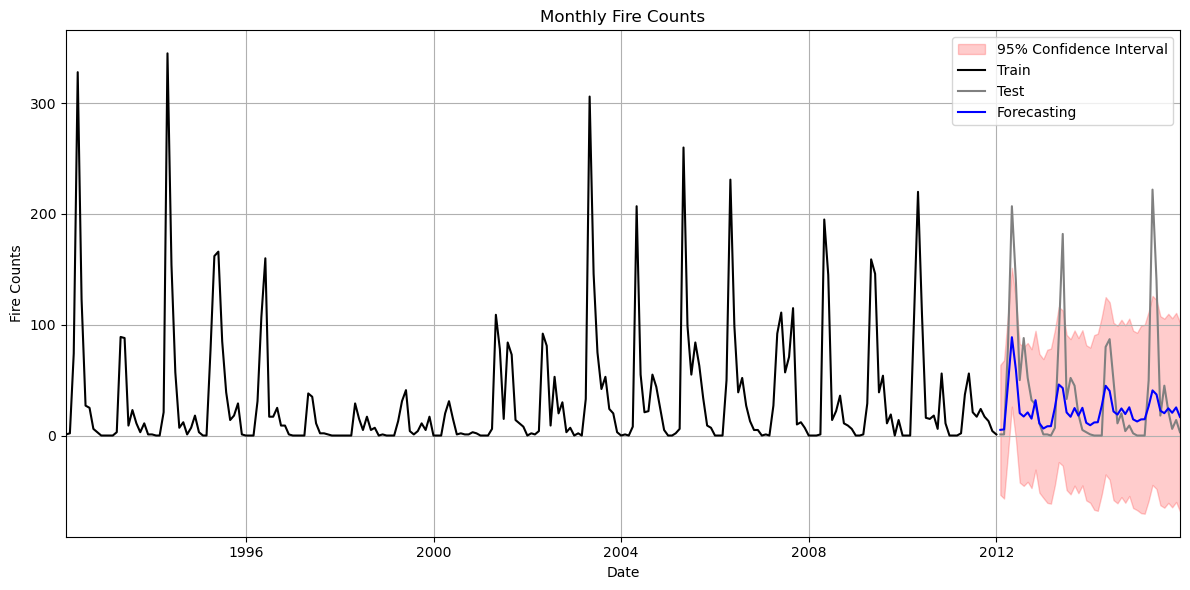

In [41]:
# Plot actual and fitted serie
plt.figure(figsize=(12, 6))                                      

# Plot 95% confidence interval
plt.fill_between(test.index,
                 conf_int_47.iloc[:, 0],     # Lower bound
                 conf_int_47.iloc[:, 1],     # Upper bound
                 color='red', alpha=0.2, label='95% Confidence Interval')

plt.plot(train.index, train['FIRE_COUNT'], label='Train', color='black')                      
plt.plot(test.index, test['FIRE_COUNT'], label='Test', color='gray')     
plt.plot(test.index, test['Forecast S'], label='Forecasting', color='blue') 

plt.title('Monthly Fire Counts')                      
plt.xlabel('Date')                                        
plt.ylabel('Fire Counts')  
plt.xlim(pd.to_datetime('1992-02-29'), pd.to_datetime('2015-11-30'))

plt.legend()
plt.grid(True)    
fig.autofmt_xdate()
plt.tight_layout()
plt.show();

# Analysis with Exogenous Variables

In [42]:
train.head()

,FIRE_COUNT,Value,Anomaly
DISCOVERY_DATE,,,
1992-02-29,1,25.1,4.4
1992-03-31,2,29.0,-1.0
1992-04-30,74,40.2,-2.5
1992-05-31,328,54.5,0.3
1992-06-30,123,60.3,-3.6


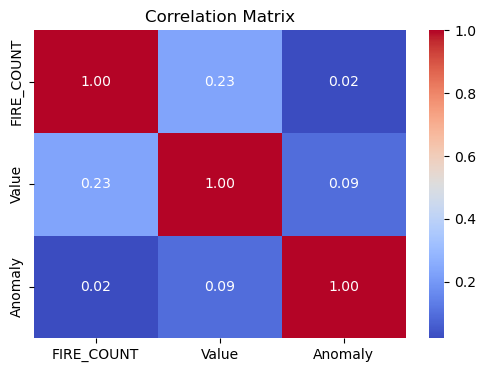

In [43]:
# Compute correlation matrix
correlation_matrix = train.corr()

plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [45]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Select candidate variables
X = train[['Value', 'Anomaly']]

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [round(variance_inflation_factor(X.values, i), 2) for i in range(len(X.columns))]

# Define VIF interpretation rules
conditions = [
    (vif_data["VIF"] < 5),
    (vif_data["VIF"] >= 5) & (vif_data["VIF"] <= 10),
    (vif_data["VIF"] > 10)
]
choices = [
    "Not Multicollinearity",
    "Moderate Multicollinearity",
    "High Multicollinearity"
]

# Add interpretation column
vif_data["Interpretation"] = np.select(conditions, choices, default="Undefined")

# Make 'Feature' as Index
vif_data.set_index('Feature', inplace=True)

# Display VIF results
print(vif_data)
print()

# Compute and display correlation matrix
corr = X.corr().round(2)
print(f'Correlation:\n{corr}')

          VIF         Interpretation
Feature                             
Value    1.04  Not Multicollinearity
Anomaly  1.04  Not Multicollinearity

Correlation:
         Value  Anomaly
Value     1.00     0.09
Anomaly   0.09     1.00


In [46]:
exog_data = train[['Value']]         # Multiple column selection
endog_data = train['FIRE_COUNT']     # Target variable selection

In [47]:
# Perform a full search over the same grid as the manual SARIMAX model
auto_model = pm.auto_arima(
    y=endog_data,               # The endogenous time series
    X=exog_data,                # The exogenous time series
    seasonal=True,              # Enable seasonal component
    m=12,                       # Seasonal period
    d=1,                        # Set differencing 
    D=0,                        # Set seasonal differencing
    start_p=0, max_p=3,         # p
    start_q=0, max_q=3,         # q
    start_P=0, max_P=3,         # P
    start_Q=0, max_Q=3,         # Q
    stepwise=True,              # Use stepwise search
    trace=False,                # Print model search progress
    error_action='ignore',      # Ignore errors
    suppress_warnings=True,     # Suppress warnings
    information_criterion='aic' # Use AIC to evaluate models
)
# Print best model
print(f"Best model: SARIMA{auto_model.order}{auto_model.seasonal_order}")

Best model: SARIMA(3, 1, 0)(3, 0, 0, 12)


In [49]:
def combinator(items, r=1):
    combo = [i for i in product(*items, repeat=r)]  # Generate Cartesian product of input lists
    return combo                                    # Return the list of combinations


P_ns, Q_ns = [0, 1, 2, 3], [0, 1, 2, 3]       # Define search ranges for non-seasonal parameters (p, q)
P_s, Q_s = [0, 1, 2, 3], [0, 1, 2, 3]         # Define search ranges for seasonal parameters (P, Q)
d = 1
D = 0
S = 12

total = len(P_ns) * len(Q_ns) * len(P_s) * len(Q_s)
print(f'Total number of models: {total}')

vals = combinator([P_ns, [d], Q_ns, P_s, [D], Q_s])  # Generate all combinations of SARIMA parameter sets

score = {}                                     # Dictionary to store model evaluation metrics

for i, (p, d, q, P, D, Q) in enumerate(vals):  # Iterate over all parameter combinations
    
    if i % 15 == 0:                            # Print progress every 15 models
        print(f'Running model #{i} using SARIMA({p},{d},{q})({P},{D},{Q},{S})')

    m = SARIMAX(endog=endog_data, 
                exog=exog_data,
                order=(p,d,q), 
                seasonal_order=(P, D, Q, S),   
                enforce_stationarity=False)    # Allow non-stationary models for broader search

    res = m.fit(disp=0, low_memory=True)       # Fit the model silently

    score[i] = {                               # Store model results and evaluation metrics
        'non-seasonal order': (p, d, q),      
        'seasonal order': (P, D, Q),
        'AIC': res.aic,                        # Akaike Information Criterion
        'model': res                           # Fitted model object
    }
print()

pd.DataFrame(score).T.sort_values(by='AIC').reset_index().head()

Total number of models: 256
Running model #0 using SARIMA(0,1,0)(0,0,0,12)
Running model #15 using SARIMA(0,1,0)(3,0,3,12)
Running model #30 using SARIMA(0,1,1)(3,0,2,12)
Running model #45 using SARIMA(0,1,2)(3,0,1,12)
Running model #60 using SARIMA(0,1,3)(3,0,0,12)
Running model #75 using SARIMA(1,1,0)(2,0,3,12)
Running model #90 using SARIMA(1,1,1)(2,0,2,12)
Running model #105 using SARIMA(1,1,2)(2,0,1,12)
Running model #120 using SARIMA(1,1,3)(2,0,0,12)
Running model #135 using SARIMA(2,1,0)(1,0,3,12)
Running model #150 using SARIMA(2,1,1)(1,0,2,12)
Running model #165 using SARIMA(2,1,2)(1,0,1,12)
Running model #180 using SARIMA(2,1,3)(1,0,0,12)
Running model #195 using SARIMA(3,1,0)(0,0,3,12)
Running model #210 using SARIMA(3,1,1)(0,0,2,12)
Running model #225 using SARIMA(3,1,2)(0,0,1,12)
Running model #240 using SARIMA(3,1,3)(0,0,0,12)
Running model #255 using SARIMA(3,1,3)(3,0,3,12)



,index,non-seasonal order,seasonal order,AIC,model
0,119,"(1, 1, 3)","(1, 0, 3)",1927.493054,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
1,55,"(0, 1, 3)","(1, 0, 3)",1927.955622,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
2,123,"(1, 1, 3)","(2, 0, 3)",1928.91159,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
3,191,"(2, 1, 3)","(3, 0, 3)",1928.911704,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
4,187,"(2, 1, 3)","(2, 0, 3)",1929.210175,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...


In [50]:
# Define the SARIMAX model with exogenous regressors
model_M = SARIMAX(endog=endog_data, 
                    exog=exog_data, 
                    order=(1, 1, 3), 
                    seasonal_order=(1, 0, 3, 12),
                    enforce_stationarity=False)

# Fit the model
model_fit_M = model_M.fit()

# Display model summary
print(model_fit_M.summary())

                                     SARIMAX Results                                      
Dep. Variable:                         FIRE_COUNT   No. Observations:                  239
Model:             SARIMAX(1, 1, 3)x(1, 0, 3, 12)   Log Likelihood                -953.747
Date:                            Mon, 05 May 2025   AIC                           1927.493
Time:                                    16:07:58   BIC                           1960.376
Sample:                                02-29-1992   HQIC                          1940.803
                                     - 12-31-2011                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Value          1.1962      0.551      2.169      0.030       0.116       2.277
ar.L1         -0.5544      0.369   

In [51]:
# Identify exogenous variables: exclude AR, MA, seasonal terms, and sigma2
exo_vars = [name for name in model_fit_M.params.index 
            if name not in ['sigma2'] and not name.startswith(('ar.', 'ma.', 'ar.S.', 'ma.S.'))]

# Loop over each exogenous variable and evaluate its statistical relevance
for var in exo_vars:
    coef = model_fit_M.params[var]
    p_val = model_fit_M.pvalues[var]
    
    print(f"{var} coefficient: {coef:.4f}")
    print(f"{var} p-value: {p_val:.4f}")
    
    if abs(coef) < 0.1 and p_val > 0.05:
        print(f"{var} is statistically IRRELEVANT in the model.\n")
    else:
        print(f"{var} is statistically RELEVANT in the model.\n")

Value coefficient: 1.1962
Value p-value: 0.0300
Value is statistically RELEVANT in the model.



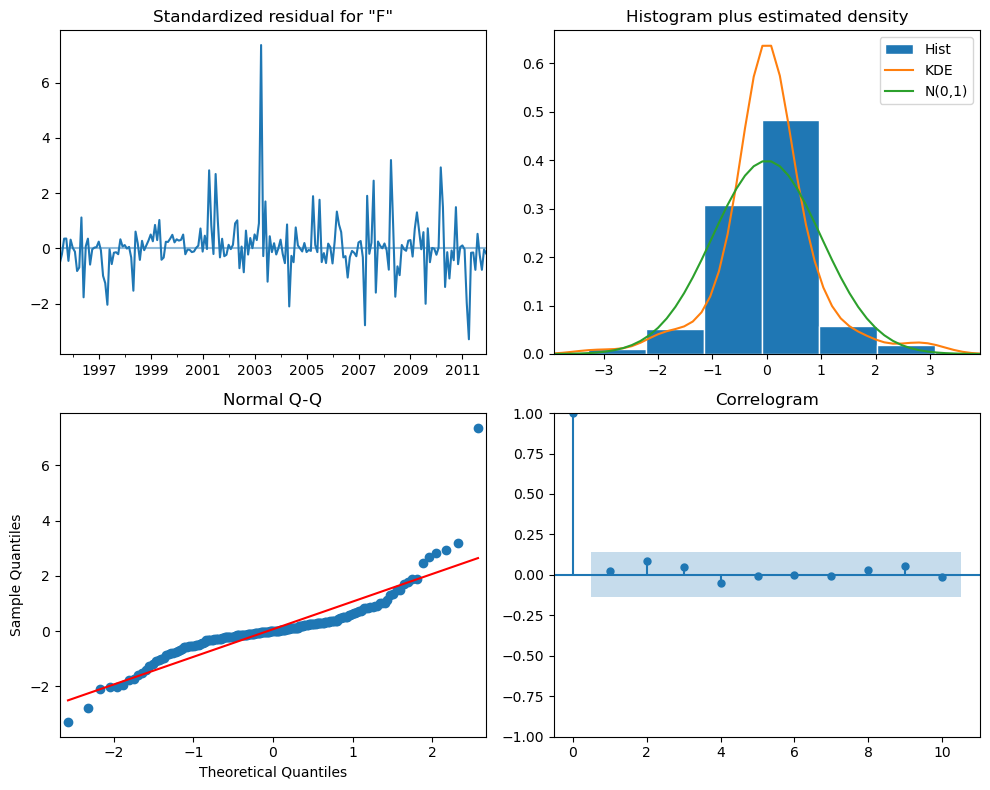

In [52]:
# Diagnostic plots for the model, including residuals and other model checks
model_fit_M.plot_diagnostics(figsize=(10, 8))
plt.tight_layout()
plt.show();

In [53]:
# Extract the residuals (errors) from the fitted model
residuals = model_fit_M.resid  

# Apply the Ljung-Box test on the residuals, on 10 lags.
df_residuals = acorr_ljungbox(residuals, np.arange(1, 11, 1))

# Check if all values in 'lb_pvalue' are lower than 0.05
if (df_residuals['lb_pvalue'] > 0.05).all():
    print('All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.\n')
else:
    print('There are p-values < 0.05; Ha: Residuals are autocorrelated.\n')

# Show Residuals
df_residuals

There are p-values < 0.05; Ha: Residuals are autocorrelated.



,lb_stat,lb_pvalue
1,0.751063,0.386140
2,12.704017,0.001743
3,14.070341,0.002811
4,14.583740,0.005647
5,14.829304,0.011117
6,14.877516,0.021231
7,15.091606,0.034843
8,15.157713,0.056150
9,17.074399,0.047564
10,17.732671,0.059644


In [54]:
# Dublin-Watson Test
dw_statistic = durbin_watson(residuals)

print(f'Durbin-Watson statistic: {dw_statistic:.4f}')

# Automatic conclusion based on the DW statistic
if dw_statistic < 0.5:
    print("Conclusion: Strong Positive autocorrelation.")
elif 0.5 <= dw_statistic <= 1.5:
    print("Conclusion: Evidence of positive autocorrelation.")
elif 1.5 <= dw_statistic <= 2.5:
    print("Conclusion: No significant autocorrelation.")
elif 2.5 <= dw_statistic <= 3.5:
    print("Conclusion: Evidence of negative autocorrelation.")
elif dw_statistic > 3.5:
    print("Conclusion: Strong negative autocorrelation.")

Durbin-Watson statistic: 1.8839
Conclusion: No significant autocorrelation.


In [55]:
# Must match the structure of training exog
exog_test_M = test[['Value']] 

# Forecast the next Time points with exogenous inputs
forecast_M = model_fit_M.get_forecast(steps=47, exog=exog_test_M)

# Extract predicted mean and confidence intervals
forecast_mean_M = forecast_M.predicted_mean
conf_int_M = forecast_M.conf_int()

# Assign forecasts to the test DataFrame
test['Forecast M'] = forecast_mean_M.values
test['Error M'] = test['Forecast M'] - test['FIRE_COUNT']
test['Lower 95% CI M'] = conf_int_M.iloc[:, 0].values
test['Upper 95% CI M'] = conf_int_M.iloc[:, 1].values

# Display updated test DataFrame
test.head()

,FIRE_COUNT,Value,Anomaly,Forecast S,Error S,Lower 95% CI S,Upper 95% CI S,Forecast M,Error M,Lower 95% CI M,Upper 95% CI M
DISCOVERY_DATE,,,,,,,,,,,
2012-01-31,1,25.1,6.0,5.114214,4.114214,-53.579130,63.807557,3.916538,2.916538,-53.835000,61.668076
2012-02-29,1,28.4,7.7,5.520524,4.520524,-56.879856,67.920903,6.176459,5.176459,-55.502029,67.854946
2012-03-31,82,44.7,14.7,46.744503,-35.255497,-15.874129,109.363135,53.386619,-28.613381,-8.380022,115.153260
2012-04-30,207,43.9,1.2,88.743979,-118.256021,26.102232,151.385726,79.516511,-127.483489,17.739163,141.293860
2012-05-31,140,59.0,4.8,59.658803,-80.341197,-2.996720,122.314326,62.793334,-77.206666,1.003610,124.583059


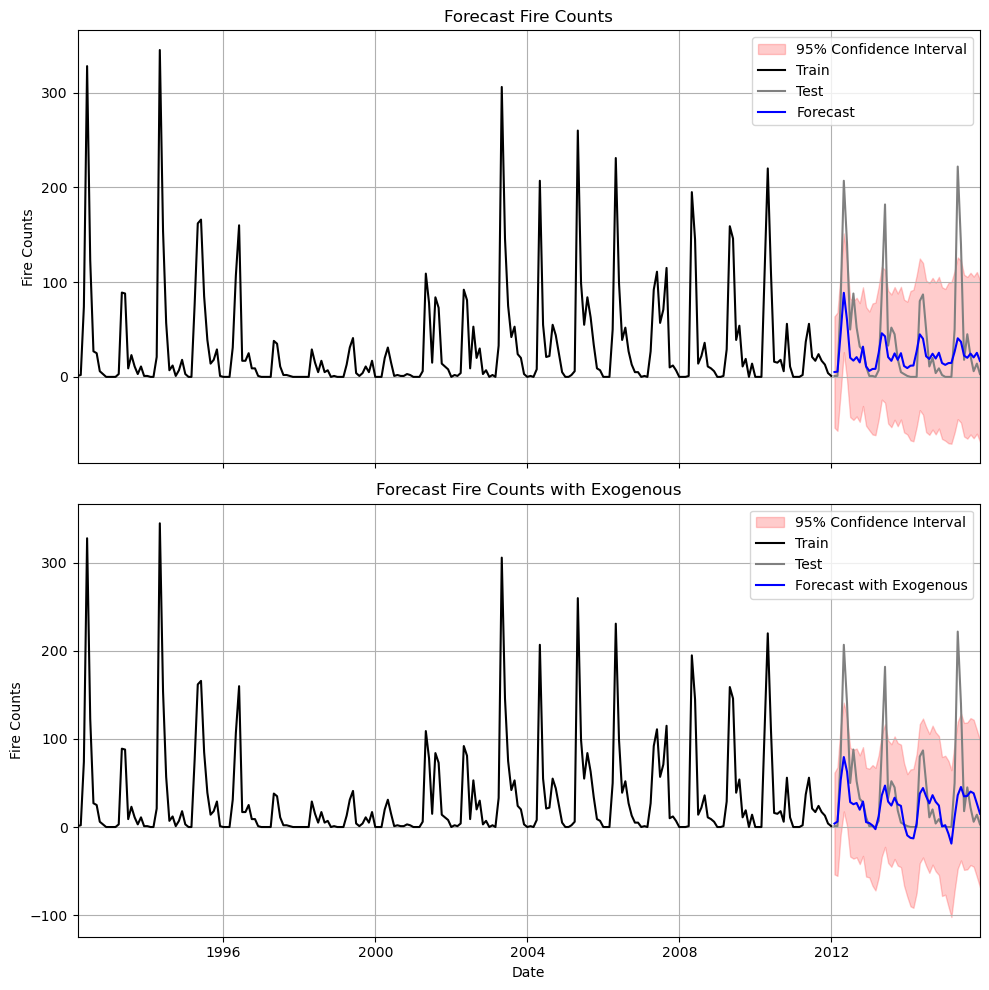

In [56]:
# Create subplots: 2 rows, 1 column
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10), sharex=True)

# --- First Forecast (Forecast103) ---
axes[0].fill_between(test.index,
                     conf_int_47.iloc[:, 0],
                     conf_int_47.iloc[:, 1],
                     color='red', alpha=0.2, label='95% Confidence Interval')

axes[0].plot(train.index, train['FIRE_COUNT'], label='Train', color='black')
axes[0].plot(test.index, test['FIRE_COUNT'], label='Test', color='gray')
axes[0].plot(test.index, test['Forecast S'], label='Forecast', color='blue')

axes[0].set_title('Forecast Fire Counts')
axes[0].set_ylabel('Fire Counts')
axes[0].legend()
axes[0].grid(True)
axes[0].set_xlim(pd.to_datetime('1992-02-29'), pd.to_datetime('2015-11-30'))

# --- Second Forecast (ForecastM) ---
axes[1].fill_between(test.index,
                     conf_int_M.iloc[:, 0],
                     conf_int_M.iloc[:, 1],
                     color='red', alpha=0.2, label='95% Confidence Interval')

axes[1].plot(train.index, train['FIRE_COUNT'], label='Train', color='black')
axes[1].plot(test.index, test['FIRE_COUNT'], label='Test', color='gray')
axes[1].plot(test.index, test['Forecast M'], label='Forecast with Exogenous', color='blue')

axes[1].set_title('Forecast Fire Counts with Exogenous')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Fire Counts')
axes[1].legend()
axes[1].grid(True)
axes[1].set_xlim(pd.to_datetime('1992-02-29'), pd.to_datetime('2015-11-30'))

# Final layout
plt.tight_layout()
plt.show()

In [59]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error


# Metrics for Forecast103
mae_s = mean_absolute_error(test['FIRE_COUNT'], test['Forecast S'])
rmse_s = np.sqrt(mean_squared_error(test['FIRE_COUNT'], test['Forecast S']))
mape_s = mean_absolute_percentage_error(test['FIRE_COUNT'], test['Forecast S']) * 100

# Metrics for ForecastM
mae_m = mean_absolute_error(test['FIRE_COUNT'], test['Forecast M'])
rmse_m = np.sqrt(mean_squared_error(test['FIRE_COUNT'], test['Forecast M']))
mape_m = mean_absolute_percentage_error(test['FIRE_COUNT'], test['Forecast M']) * 100

# Combine into dictionaries
metrics_S = {
    'MAE': mae_s,
    'RMSE': rmse_s,
    #'MAPE': mape_s,
}
metrics_M = {
    'MAE': mae_m,
    'RMSE': rmse_m,
    #'MAPE': mape_m,
}

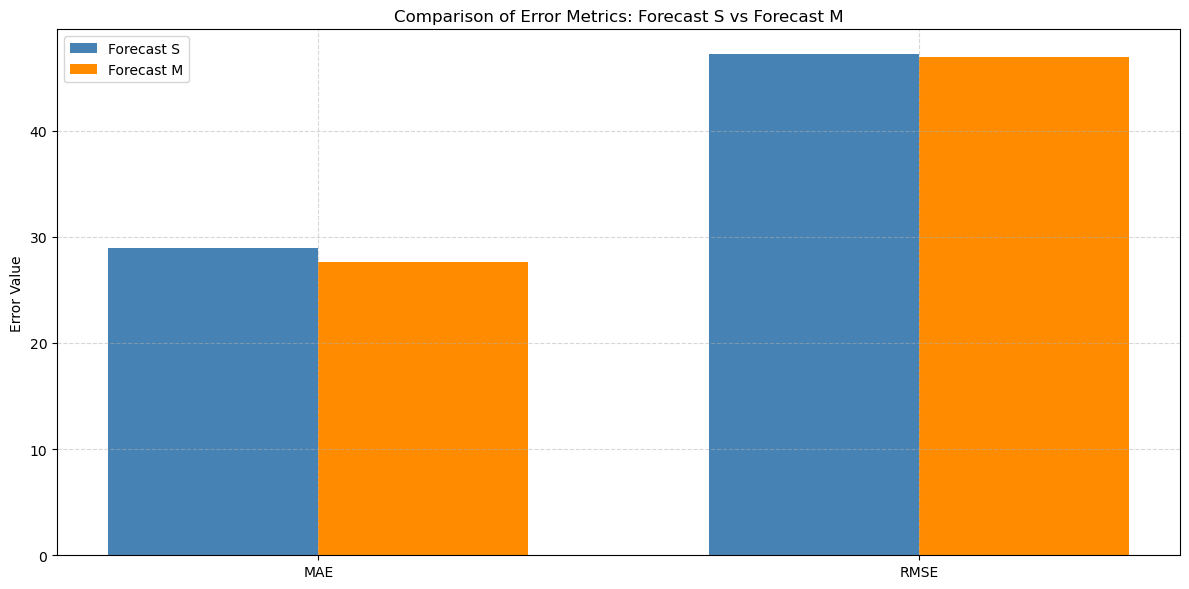

In [60]:
# Plotting
labels = list(metrics_S.keys())
values_S = list(metrics_S.values())
values_M = list(metrics_M.values())

x = range(len(labels))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar([i - width/2 for i in x], values_S, width=width, label='Forecast S', color='steelblue')
plt.bar([i + width/2 for i in x], values_M, width=width, label='Forecast M', color='darkorange')

plt.xticks(x, labels)
plt.ylabel("Error Value")
plt.title("Comparison of Error Metrics: Forecast S vs Forecast M")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [61]:
# Create DataFrame for Error Analysis
comparison_df = pd.DataFrame([metrics_S, metrics_M], index=['Forecast S', 'Forecast M']).T.round(2) 
comparison_df

,Forecast S,Forecast M
MAE,28.95,27.67
RMSE,47.19,46.96


In [62]:
#Augmented Dickey-Fuller test for stationary checking

monthly_fire_counts = final_df.resample('ME').size()

adf_result = adfuller(monthly_fire_counts)

print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print('\t%s: %.3f' % (key, value))

if adf_result[1] < 0.05:
    print("The time series is stationary. Approved for ARIMA models")
else:
    print("The time series is not stationary.")

ADF Statistic: -3.036582
p-value: 0.031616
Critical Values:
	1%: -3.455
	5%: -2.872
	10%: -2.572
The time series is stationary. Approved for ARIMA models


In [63]:
def determine_nonseasonal_d(series, max_d=2, alpha=0.05):

    d = 0

    adf_result = adfuller(series)                # Run ADF test on the original series
    p_value = adf_result[1]
    print(f"d = {d} | ADF Statistic = {adf_result[0]:.4f}, p-value = {p_value:.4f}")

    if p_value < alpha:                          # If the original series is stationary
        
        return d
        
    else:
        while p_value > alpha and d < max_d:
            d += 1
            series = np.diff(series, n=1)        # Perform first-order differencing
            ad_fuller_result1 = adfuller(series)  
            p_value = ad_fuller_result1[1]
            print(f"d = {d} | ADF Statistic = {ad_fuller_result1[0]:.4f}, p-value = {p_value:.4f}")   
            
        return d  

d = determine_nonseasonal_d(fire_series)
print(f"\nNon-seasonal differencing term (d): {d}")

d = 0 | ADF Statistic = -2.4803, p-value = 0.1203
d = 1 | ADF Statistic = -9.2320, p-value = 0.0000

Non-seasonal differencing term (d): 1


End.